In [1]:
# ------------------------------------------------------------------------------ #
# @Author:        L. Rudelt
# @Email:         lucas.rudelt@ds.mpg.de
# @Created:       2023-11-16 16:49:35
# @Last Modified: 
# ------------------------------------------------------------------------------ #

%reload_ext autoreload
%autoreload 2
%reload_ext ipy_dict_hierarchy
%reload_ext watermark

import logging
logging.basicConfig(
    format="%(asctime)s | %(levelname)-8s | %(name)-s | %(funcName)-s | %(message)s",
    level=logging.WARNING,
)
log = logging.getLogger("notebook")
log.setLevel("DEBUG")

import re
import glob
import h5py
import sys
import os
import numpy as np
import xarray as xr
import pandas as pd
import dask

from tqdm import tqdm


# also needs to be added for each dask-worker
extra_path = os.path.abspath('../')
sys.path.append(extra_path)
log.info(f"project directory: {extra_path}")

from ana import utility as utl
from ana import plot_helper as ph

ph.log.setLevel("DEBUG")
utl.log.setLevel("DEBUG")

data_dir = "../dat/"

2025-01-13 22:41:19,119 | INFO     | notebook | <module> | project directory: /home/carlos/Git/CarlosErnestoMA/mouse_visual_timescales/experiment_analysis


In [2]:
# load our results from timescale fitting
meta_df = pd.read_hdf(f"{data_dir}/all_units_merged_blocks_with_spont.h5", key="meta_df")

# add metrics from image selectivity etc.
meta_df = utl.load_metrics(meta_df.reset_index(), data_dir)
meta_df

2025-01-13 22:41:24,956 | DEBUG    | its_utility | load_metrics | Loaded columns ['unit_id', 'g_dsi_dg', 'mod_idx_dg', 'on_screen_rf', 'image_selectivity_ns'] from /home/carlos/Git/CarlosErnestoMA/mouse_visual_timescales/experiment_analysis/dat/brain_observatory_unit_metrics_filtered.csv
2025-01-13 22:41:24,958 | DEBUG    | its_utility | load_metrics | Matched 6368 rows from meta_df in /home/carlos/Git/CarlosErnestoMA/mouse_visual_timescales/experiment_analysis/dat/brain_observatory_unit_metrics_filtered.csv


,unit_id,stimulus,session,block,ecephys_structure_acronym,invalid_spiketimes_check,recording_length,firing_rate,filepath,num_spikes,...,tau_R,tau_single,tau_double,tau_R_details,tau_single_details,tau_double_details,g_dsi_dg,image_selectivity_ns,mod_idx_dg,on_screen_rf
0,950911932,natural_movie_three,715093703,merged_3.0_and_6.0,VISam,SUCCESS,1078.491211,8.025100,/project.nst/neuroscience-raw/Allen/visual_cod...,8655,...,0.058510,0.000054,0.748946,"{'firing_rate': 8.012090922999178, 'firing_rat...","{'tau': 5.404084198337884e-05, 'mre': 6.575654...","{'tau': 0.7489462162647652, 'mre': 0.993346188...",0.095447,0.164169,1.353636,False
1,950911986,natural_movie_three,715093703,merged_3.0_and_6.0,VISam,SUCCESS,1079.203369,3.647135,/project.nst/neuroscience-raw/Allen/visual_cod...,3936,...,0.088701,2.302634,1.874703,"{'firing_rate': 3.6471291367256455, 'firing_ra...","{'tau': 2.3026338728859774, 'mre': 0.997830929...","{'tau': 1.874703126979266, 'mre': 0.9973364645...",0.108358,0.017271,0.639408,[False]
2,950912164,natural_movie_three,715093703,merged_3.0_and_6.0,VISam,SUCCESS,1077.872803,8.500075,/project.nst/neuroscience-raw/Allen/visual_cod...,9162,...,0.059416,1.026283,1.026284,"{'firing_rate': 8.475008697669026, 'firing_rat...","{'tau': 1.0262833654998276, 'mre': 0.995139899...","{'tau': 1.0262836602024297, 'mre': 0.995139901...",0.228699,0.598220,1.030492,[True]
3,950912190,natural_movie_three,715093703,merged_3.0_and_6.0,VISam,SUCCESS,1075.171875,4.399297,/project.nst/neuroscience-raw/Allen/visual_cod...,4730,...,0.116100,1.564297,1.363502,"{'firing_rate': 4.395563512916502, 'firing_rat...","{'tau': 1.5642971952849982, 'mre': 0.996808779...","{'tau': 1.363502294341311, 'mre': 0.9963396881...",0.056741,0.348424,0.999923,[True]
4,950912214,natural_movie_three,715093703,merged_3.0_and_6.0,VISam,SUCCESS,1073.492432,5.326540,/project.nst/neuroscience-raw/Allen/visual_cod...,5718,...,0.064748,0.605686,0.377801,"{'firing_rate': 5.317211538013684, 'firing_rat...","{'tau': 0.6056864214354767, 'mre': 0.991778883...","{'tau': 0.37780093267583975, 'mre': 0.98685270...",0.069080,0.422288,0.219870,[True]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17944,950942400,spontaneous,771160300,null,VISal,SUCCESS,1797.115234,0.377828,/project.nst/neuroscience-raw/Allen/visual_cod...,679,...,0.049446,0.257024,0.217925,"{'firing_rate': 0.36583331347267567, 'firing_r...","{'tau': 0.25702383931940154, 'mre': 0.98073454...","{'tau': 0.2179251442600049, 'mre': 0.977317546...",NaN,NaN,NaN,NaN
17945,950944614,spontaneous,771160300,null,VISal,SUCCESS,1792.901855,0.377600,/project.nst/neuroscience-raw/Allen/visual_cod...,677,...,0.042486,0.439570,0.057439,"{'firing_rate': 0.38629086027452963, 'firing_r...","{'tau': 0.4395698459887982, 'mre': 0.988689691...","{'tau': 0.05743850656844875, 'mre': 0.91663161...",NaN,NaN,NaN,NaN
17946,950943984,spontaneous,771160300,null,VISal,SUCCESS,1773.977051,0.135289,/project.nst/neuroscience-raw/Allen/visual_cod...,240,...,0.043392,0.170987,0.170986,"{'firing_rate': 0.13628681470096451, 'firing_r...","{'tau': 0.1709865057191234, 'mre': 0.971181338...","{'tau': 0.17098641292634262, 'mre': 0.97118132...",NaN,NaN,NaN,NaN
17947,950942680,spontaneous,771160300,null,VISal,SUCCESS,1801.591797,12.195324,/project.nst/neuroscience-raw/Allen/visual_cod...,21971,...,0.008184,0.081918,0.068260,"{'firing_rate': 12.154834329411557, 'firing_ra...","{'tau': 0.08191797577480081, 'mre': 0.94078874...","{'tau': 0.06826005692776223, 'mre': 0.92936912...",NaN,NaN,NaN,NaN


In [ ]:
assert (
    len(meta_df.query("stimulus == 'natural_movie_three'"))
    == np.isfinite(
        meta_df.query("stimulus == 'natural_movie_three'")["mod_idx_dg"]
    ).sum()
)

# exclude nans for now ~ 5 rows with low rates and one todo for unit 951021415
# TODO: 0.05 firing rate threshold seems better
meta_df = meta_df.query("R_tot == R_tot")
meta_df = meta_df.query("firing_rate > 0.05")
# Set R_tot to zero if it is negative (can be the case when predictability is very low, due to estimation error)
meta_df = meta_df.query("R_tot > 0")

In [3]:
# we need a mapping from ephys acronyms to the names we use in the paper
structure_names = {
    "VISp" : "V1",
    "VISl" : "LM",
    "VISrl" : "RL",
    "VISal" : "AL",
    "VISpm" : "PM",
    "VISam" : "AM",
    "LGd" : "LGN",
    "LP" : "LP",
}

# apply to dataframe
meta_df["structure_name"] = meta_df["ecephys_structure_acronym"].apply(
    lambda x: structure_names[x]
)

In [4]:
# df = meta_df.query("(stimulus == 'natural_movie_one_more_repeats')")
df = meta_df.query("(stimulus == 'natural_movie_one_more_repeats')")
df 

,unit_id,stimulus,session,block,ecephys_structure_acronym,invalid_spiketimes_check,recording_length,firing_rate,filepath,num_spikes,...,tau_single,tau_double,tau_R_details,tau_single_details,tau_double_details,g_dsi_dg,image_selectivity_ns,mod_idx_dg,on_screen_rf,structure_name
5264,950913540,natural_movie_one_more_repeats,766640955,merged_3.0_and_8.0,VISam,SUCCESS,1679.128662,5.992394,/project.nst/neuroscience-raw/Allen/visual_cod...,10062,...,0.444751,0.266734,"{'firing_rate': 5.424833098092464, 'firing_rat...","{'tau': 0.4447514704975335, 'mre': 0.988820723...","{'tau': 0.26673397442951513, 'mre': 0.98142933...",NaN,NaN,NaN,NaN,AM
5265,950913832,natural_movie_one_more_repeats,766640955,merged_3.0_and_8.0,VISam,SUCCESS,1657.488525,0.949630,/project.nst/neuroscience-raw/Allen/visual_cod...,1574,...,0.436281,0.372662,"{'firing_rate': 0.9490253334861749, 'firing_ra...","{'tau': 0.436280674700545, 'mre': 0.9886049092...","{'tau': 0.3726615769901148, 'mre': 0.986672607...",NaN,NaN,NaN,NaN,AM
5266,950913944,natural_movie_one_more_repeats,766640955,merged_3.0_and_8.0,VISam,SUCCESS,1679.926514,20.808648,/project.nst/neuroscience-raw/Allen/visual_cod...,34957,...,0.616284,0.615629,"{'firing_rate': 20.71931568577262, 'firing_rat...","{'tau': 0.6162838326966938, 'mre': 0.991919677...","{'tau': 0.6156289162941389, 'mre': 0.991911116...",NaN,NaN,NaN,NaN,AM
5267,950913961,natural_movie_one_more_repeats,766640955,merged_3.0_and_8.0,VISam,SUCCESS,1679.304443,2.747566,/project.nst/neuroscience-raw/Allen/visual_cod...,4614,...,1.079452,0.671559,"{'firing_rate': 2.7332735863943713, 'firing_ra...","{'tau': 1.0794517026161248, 'mre': 0.995378729...","{'tau': 0.6715590684342057, 'mre': 0.992582286...",NaN,NaN,NaN,NaN,AM
5268,950913984,natural_movie_one_more_repeats,766640955,merged_3.0_and_8.0,VISam,SUCCESS,1676.084473,5.225870,/project.nst/neuroscience-raw/Allen/visual_cod...,8759,...,2.507153,0.249960,"{'firing_rate': 5.2043899921543355, 'firing_ra...","{'tau': 2.5071528534603122, 'mre': 0.998007693...","{'tau': 0.24996004535420216, 'mre': 0.98019553...",NaN,NaN,NaN,NaN,AM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11922,951190716,natural_movie_one_more_repeats,847657808,merged_3.0_and_8.0,LP,SUCCESS,1669.521729,3.438110,/project.nst/neuroscience-raw/Allen/visual_cod...,5740,...,0.154983,0.147879,"{'firing_rate': 3.3512526017879334, 'firing_ra...","{'tau': 0.15498293185242107, 'mre': 0.96825323...","{'tau': 0.1478788520828995, 'mre': 0.966753758...",NaN,NaN,NaN,NaN,LP
11923,951190722,natural_movie_one_more_repeats,847657808,merged_3.0_and_8.0,LP,SUCCESS,1677.163818,2.705758,/project.nst/neuroscience-raw/Allen/visual_cod...,4538,...,0.287762,0.248368,"{'firing_rate': 2.6944277992922583, 'firing_ra...","{'tau': 0.2877620706377681, 'mre': 0.982774617...","{'tau': 0.24836808551088616, 'mre': 0.98006987...",NaN,NaN,NaN,NaN,LP
11924,951190724,natural_movie_one_more_repeats,847657808,merged_3.0_and_8.0,LP,SUCCESS,1676.766846,2.142814,/project.nst/neuroscience-raw/Allen/visual_cod...,3593,...,0.345960,0.312267,"{'firing_rate': 2.132075359172695, 'firing_rat...","{'tau': 0.34596009410375744, 'mre': 0.98565140...","{'tau': 0.3122666989915499, 'mre': 0.984115555...",NaN,NaN,NaN,NaN,LP
11925,951190819,natural_movie_one_more_repeats,847657808,merged_3.0_and_8.0,LP,SUCCESS,1675.092041,1.989741,/project.nst/neuroscience-raw/Allen/visual_cod...,3333,...,0.326839,0.326856,"{'firing_rate': 1.9873499711956635, 'firing_ra...","{'tau': 0.3268387313372349, 'mre': 0.984818356...","{'tau': 0.3268561287459293, 'mre': 0.984819158...",NaN,NaN,NaN,NaN,LP


### Compute mean over natural stimulus blocks 

In [6]:
# get values for "ecephys_structure_acronym" from df for unique units
df_mean = df.groupby("unit_id")["ecephys_structure_acronym"].first()
# append the stimulus
df_mean = pd.merge(df_mean, df.groupby("unit_id")["stimulus"].first(), left_index=True, right_index=True)
# add column "block" with all entries equal to "averaged"   
df_mean["block"] = "averaged"
# now append the mean of R_tot, tau_R, tau_single, tau_double
df_mean = pd.merge(df_mean, df.groupby("unit_id")["R_tot"].mean(), left_index=True, right_index=True)
df_mean = pd.merge(df_mean, df.groupby("unit_id")["tau_R"].mean(), left_index=True, right_index=True)
df_mean = pd.merge(df_mean, df.groupby("unit_id")["tau_single"].mean(), left_index=True, right_index=True)
df_mean = pd.merge(df_mean, df.groupby("unit_id")["tau_double"].mean(), left_index=True, right_index=True)
df_mean = pd.merge(df_mean, df.groupby("unit_id")["firing_rate"].mean(), left_index=True, right_index=True)

df_mean


,ecephys_structure_acronym,stimulus,block,R_tot,tau_R,tau_single,tau_double,firing_rate
unit_id,,,,,,,,
950912119,VISam,natural_movie_one_more_repeats,averaged,0.103835,0.094123,0.539511,0.314340,4.072803
950912127,VISam,natural_movie_one_more_repeats,averaged,0.115858,0.092584,0.962307,0.962309,3.658650
950912162,VISam,natural_movie_one_more_repeats,averaged,0.095335,0.005845,-6681.987998,0.614475,32.995879
950912200,VISam,natural_movie_one_more_repeats,averaged,0.187554,0.112925,1.474542,39.603164,4.325964
950912241,VISam,natural_movie_one_more_repeats,averaged,0.116052,0.153836,2.966076,5.580898,1.046864
...,...,...,...,...,...,...,...,...
951190716,LP,natural_movie_one_more_repeats,averaged,0.082713,0.057480,0.154983,0.147879,3.438110
951190722,LP,natural_movie_one_more_repeats,averaged,0.061618,0.179228,0.287762,0.248368,2.705758
951190724,LP,natural_movie_one_more_repeats,averaged,0.075886,0.067158,0.345960,0.312267,2.142814


### Plot groups and hierarchy for averaged values for reference

2025-01-13 22:44:32,825 | INFO     | plot_helper | panel_areas_grouped | grouped tau_double for ['natural_movie_one_more_repeats'] ['averaged'] with 5556 rows
2025-01-13 22:44:32,829 | DEBUG    | plot_helper | panel_areas_grouped | dropping 26 rows with too large timescales
2025-01-13 22:44:32,831 | DEBUG    | plot_helper | panel_areas_grouped | thalamus_grouped has 765 rows
2025-01-13 22:44:33,030 | DEBUG    | plot_helper | panel_areas_grouped | thalamus_grouped median_bs: 0.22, median: 0.22 quantiles: [0.20740442 0.2321761 ]
2025-01-13 22:44:33,395 | DEBUG    | plot_helper | panel_areas_grouped | dropping 17 rows with too large timescales
2025-01-13 22:44:33,396 | DEBUG    | plot_helper | panel_areas_grouped | V1_grouped has 1020 rows
2025-01-13 22:44:33,594 | DEBUG    | plot_helper | panel_areas_grouped | V1_grouped median_bs: 0.30, median: 0.30 quantiles: [0.28024127 0.33890443]
2025-01-13 22:44:33,798 | DEBUG    | plot_helper | panel_areas_grouped | dropping 162 rows with too larg

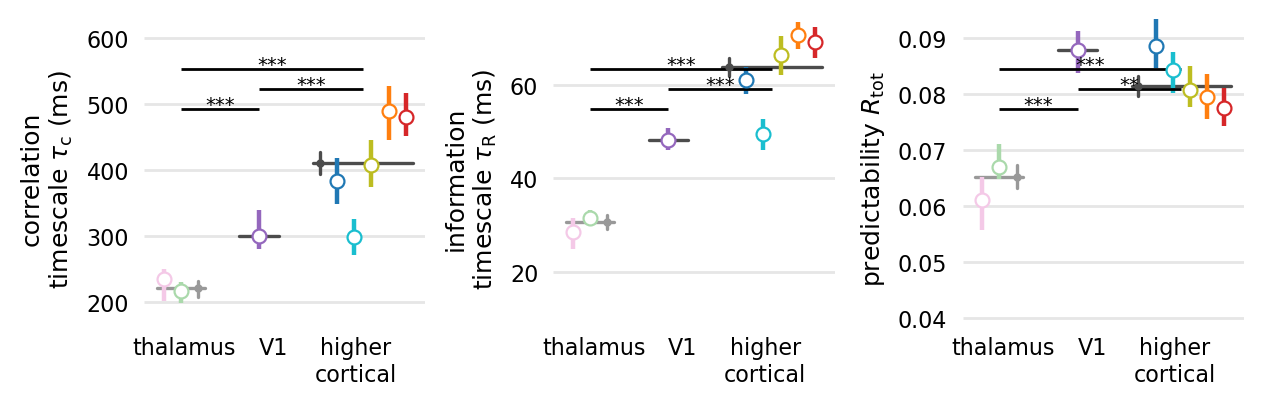

In [7]:
df_mean = df_mean.query("R_tot == R_tot")
df_mean = df_mean.query("tau_R == tau_R")
ph.row_structure_groups(df_mean);

2025-01-13 22:44:45,944 | INFO     | plot_helper | panel_hierarchy_score | dropping LGN and LP to focus on cortical hierarchy
2025-01-13 22:44:45,947 | INFO     | plot_helper | panel_hierarchy_score | plotting tau_double agains hierarchy score for ['natural_movie_one_more_repeats'] ['averaged'] with 4765 rows
2025-01-13 22:44:45,948 | DEBUG    | plot_helper | panel_hierarchy_score | dropping 179 rows with too large timescales
2025-01-13 22:44:46,151 | DEBUG    | plot_helper | panel_hierarchy_score | AM median_bs: 0.48, median: 0.48 quantiles: [0.45195276 0.51660313]
2025-01-13 22:44:46,349 | DEBUG    | plot_helper | panel_hierarchy_score | PM median_bs: 0.49, median: 0.49 quantiles: [0.44529204 0.52749357]
2025-01-13 22:44:46,548 | DEBUG    | plot_helper | panel_hierarchy_score | V1 median_bs: 0.30, median: 0.30 quantiles: [0.28024127 0.33890443]
2025-01-13 22:44:46,741 | DEBUG    | plot_helper | panel_hierarchy_score | LM median_bs: 0.38, median: 0.38 quantiles: [0.34798289 0.41821992

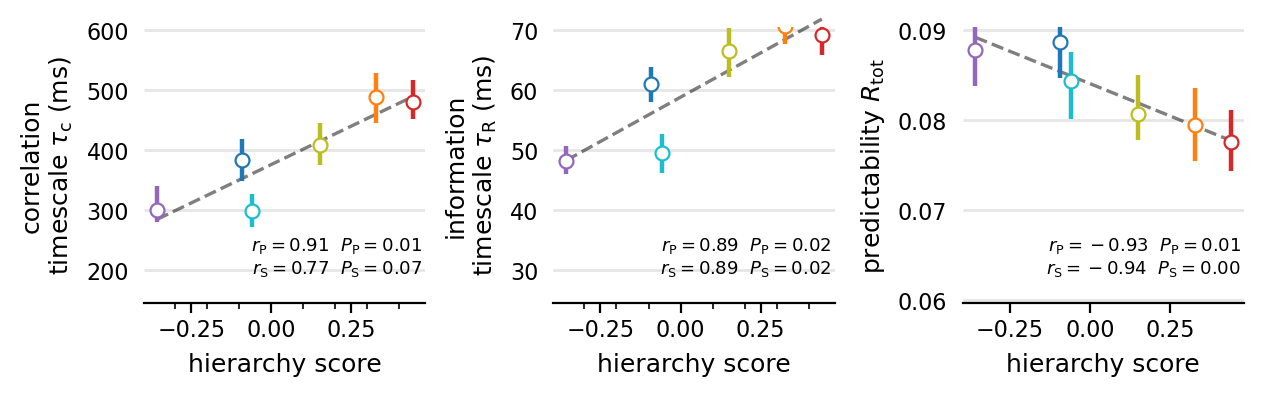

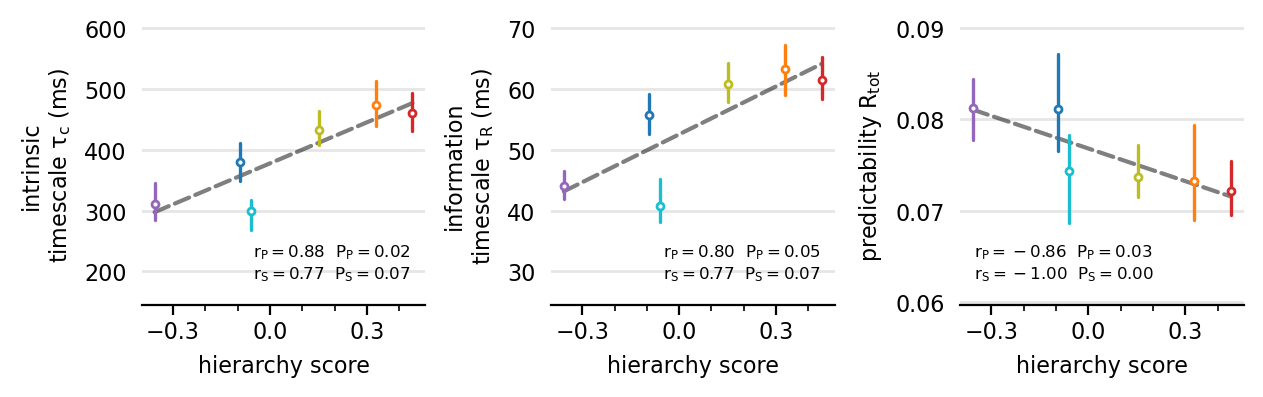

In [8]:
ph.row_hierarchy_score(df_mean);

### Add layer information to data frame

In [9]:
# Add layer data to the data frame
layers = pd.read_csv(f"{data_dir}/layers.csv", index_col=0)
# merge df_mean and layers only for units in df_mean
df_mean = pd.merge(df_mean, layers, left_index=True, right_index=True)


### Plot measures for different cortical layers for each area

In [10]:
# Define function for plotting measures for different cortical layers for each area
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu

structure_colors = {
    "V1": "#9467BD",
    "LM": "#2078B4",
    "RL": "#1ABECF",
    "AL": "#BDBD21",
    "PM": "#FF7F0F",
    "AM": "#D62729",
    "LGN": "#F4C9E7",
    "LP": "#AAD9AB",
    "thalamus_grouped": "#999999",
    "V1_grouped": "#4C4C4C",
    "higher_grouped": "#4C4C4C",
}


def get_CI_median(data):
    N_data = len(data)
    median_data = np.sort(
        np.nanmedian(np.random.choice(data, size=(10000, N_data)), axis=1)
    )
    CI_lo = median_data[249]
    CI_hi = median_data[9749]
    return CI_lo, CI_hi


# boxplot parameters
boxprops = dict(linewidth=1.5, edgecolor="black")
medianprops = dict(linestyle="-", linewidth=2.5, color="red")
whiskerprops = dict(linewidth=1.5, linestyle="--", color="black")
capprops = dict(linewidth=1.5, linestyle="-", color="black")

areas = ["VISp", "VISl", "VISrl", "VISal", "VISpm", "VISam"]


def plot_layerwise(
    fig,
    axs,
    measure,
    df,
    areas=areas,
    structure_names=structure_names,
    structure_colors=structure_colors,
):
    m_bonferroni = len(areas) * 3
    for i, area in enumerate(areas):
        n_units = len(
            df.query(f"ecephys_structure_acronym == '{area}'")[measure].values
        )
        axs[i].set_title(structure_names[area], fontsize=12, loc="center"
        )
        color = structure_colors[structure_names[area]]

        # df.query(f"ecephys_structure_acronym == '{area}'").groupby("layer")["measure"].median().plot(ax=axs[i], title=structure_names[area])
        # iterate over unique layers in df for given area and plot boxplot over R_tot values
        measure_data_per_layer = []
        for j, layer in enumerate([2, 4, 5, 6]):
            measure_data = df.query(f"ecephys_structure_acronym == '{area}'")[measure][
                df["layer"] == layer
            ].values
            measure_data_per_layer.append(measure_data)
            boxplot = axs[i].boxplot(
                measure_data,
                positions=[j],
                widths=0.5,
                showfliers=False,
                patch_artist=True,
                boxprops=boxprops,
                medianprops=medianprops,
                whiskerprops=whiskerprops,
                capprops=capprops,
            )
            # remove median from boxplot
            boxplot["medians"][0].set_linewidth(0.0)
            boxplot["boxes"][0].set_facecolor(color)
            boxplot["boxes"][0].set_alpha(0.2)
            # add median value
            median = np.median(measure_data)
            print(area, layer, median)
            axs[i].scatter(j, median, marker="o", color=color, s=30, zorder=10)
            # add error bars
            # Compute confidence interval on median from bootstrap samples
            measure_per_layer_low, measure_per_layer_high = get_CI_median(measure_data)
            axs[i].errorbar(
                j,
                median,
                yerr=[
                    [median - measure_per_layer_low],
                    [measure_per_layer_high - median],
                ],
                fmt="_",
                color=color,
                linewidth=2,
                capsize=5,
                zorder=10,
            )
            # add p-value
            if j > 0:
                layer1_measure = measure_data_per_layer[j - 1]
                layer2_measure = measure_data_per_layer[j]
                y_prev = y
                # Perform Mann-Whitney U test
                statistic, p_value = mannwhitneyu(layer1_measure, layer2_measure)
                x1, x2 = j - 1 + 0.1, j - 0.1
                y, h, col = boxplot["whiskers"][1].get_ydata()[1], 0.01, "k"
                # bonferroni correction
                p_value = p_value * m_bonferroni
                if measure == "tau_double":
                    h = 0.15
                y_max = np.amax([y, y_prev])
                # Check significance and add brackets on top of box plots
                if p_value < 0.001:
                    # y = 1.2 + j*0.5
                    axs[i].plot(
                        [x1, x1, x2, x2],
                        [y_max + h, y_max + h, y_max + h, y_max + h],
                        linewidth=1.5,
                        color=col,
                    )
                    axs[i].text(
                        (x1 + x2) * 0.5,
                        y_max + h,
                        "***",
                        ha="center",
                        va="bottom",
                        color=col,
                    )
                elif p_value < 0.01:
                    # y = 1.2 + j*0.5
                    axs[i].plot(
                        [x1, x1, x2, x2],
                        [y_max + h, y_max + h, y_max + h, y_max + h],
                        linewidth=1.5,
                        color=col,
                    )
                    axs[i].text(
                        (x1 + x2) * 0.5,
                        y_max + h,
                        "**",
                        ha="center",
                        va="bottom",
                        color=col,
                    )
                elif p_value < 0.05:
                    # y = 1.2 + j*0.5
                    axs[i].plot(
                        [x1, x1, x2, x2],
                        [y_max + h, y_max + h, y_max + h, y_max + h],
                        linewidth=1.5,
                        color=col,
                    )
                    axs[i].text(
                        (x1 + x2) * 0.5,
                        y_max + h,
                        "*",
                        ha="center",
                        va="bottom",
                        color=col,
                    )
            else:
                y = boxplot["whiskers"][1].get_ydata()[1]
        axs[i].set_xticks(np.arange(len(np.unique(layers)[2:])))
        axs[i].spines["top"].set_bounds(0, 0)
        # axs[i].spines["bottom"].set_bounds(0,3)
        # axs[i].spines["left"].set_bounds(0,6)
        axs[i].spines["right"].set_bounds(0, 0)
        # axs[i].text(
        #     0.0,
        #     1.15,
        #     f"$n={n_units}$",
        #     va="top",
        #     transform=axs[i].transAxes,
        #     fontsize=10,
        # )
        if measure == "R_tot" or measure == "tau_R":
            axs[i].set_ylim([-0.01, 0.26])
            axs[i].spines["left"].set_bounds(0, 0.25)
        elif measure == "tau_double":
            axs[i].spines["left"].set_bounds(0, 3.0)
        axs[i].set_xticklabels(["2/3", "4", "5", "6"], fontsize=10)
        # plt.xticks(fontsize=9)
    if measure == "R_tot":
        axs[0].set_ylabel(r"predictability $R_{\mathregular{tot}}$", fontsize=12)
        axs[0].set_yticks([0.0, 0.05, 0.10, 0.15, 0.20, 0.25])
    elif measure == "tau_double":
        axs[0].set_ylabel(
            "intrinsic\n" + r"timescale $τ_{\mathregular{C}}$ (sec)", fontsize=12
        )
        axs[0].set_ylim([-0.1, 3.5])
        axs[0].set_yticks([0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0])
    elif measure == "tau_R":
        axs[0].set_ylabel(
            "information\n" + r"timescale $τ_{\mathregular{R}}$ (sec)", fontsize=12
        )
        axs[0].set_yticks([0.0, 0.05, 0.10, 0.15, 0.20, 0.25])
    axs[0].tick_params(axis="y", which="major", labelsize=9)
    # # Set x-axis labels
    # plt.xticks(
    #     np.arange(len(np.unique(layers)[2:])), ["2/3", "4", "5", "6"], fontsize=10
    # )
    # plt.yticks(fontsize=10)
    # # Set common x-axis label

### Plot for predictability

VISp 2 0.10821615108437711
VISp 4 0.09025729123016614
VISp 5 0.06746473773551334
VISp 6 0.09290740151253404
VISl 2 0.0989864699339665
VISl 4 0.08750786964949613
VISl 5 0.07988698596754593
VISl 6 0.09506297339604937
VISrl 2 0.08837151751534442
VISrl 4 0.07868581748855988
VISrl 5 0.08359855099146114
VISrl 6 0.08996606120675167
VISal 2 0.09195138319598978
VISal 4 0.08650787557796813
VISal 5 0.07120317269919413
VISal 6 0.08952927272811605
VISpm 2 0.0969449840065659
VISpm 4 0.08785283424453715
VISpm 5 0.06609942594338125
VISpm 6 0.0986740721786437
VISam 2 0.08349622254715605
VISam 4 0.09028140675161782
VISam 5 0.0685633545381776
VISam 6 0.09741805488166622


FileNotFoundError: [Errno 2] No such file or directory: '../figs/layerwise_predictability.png'

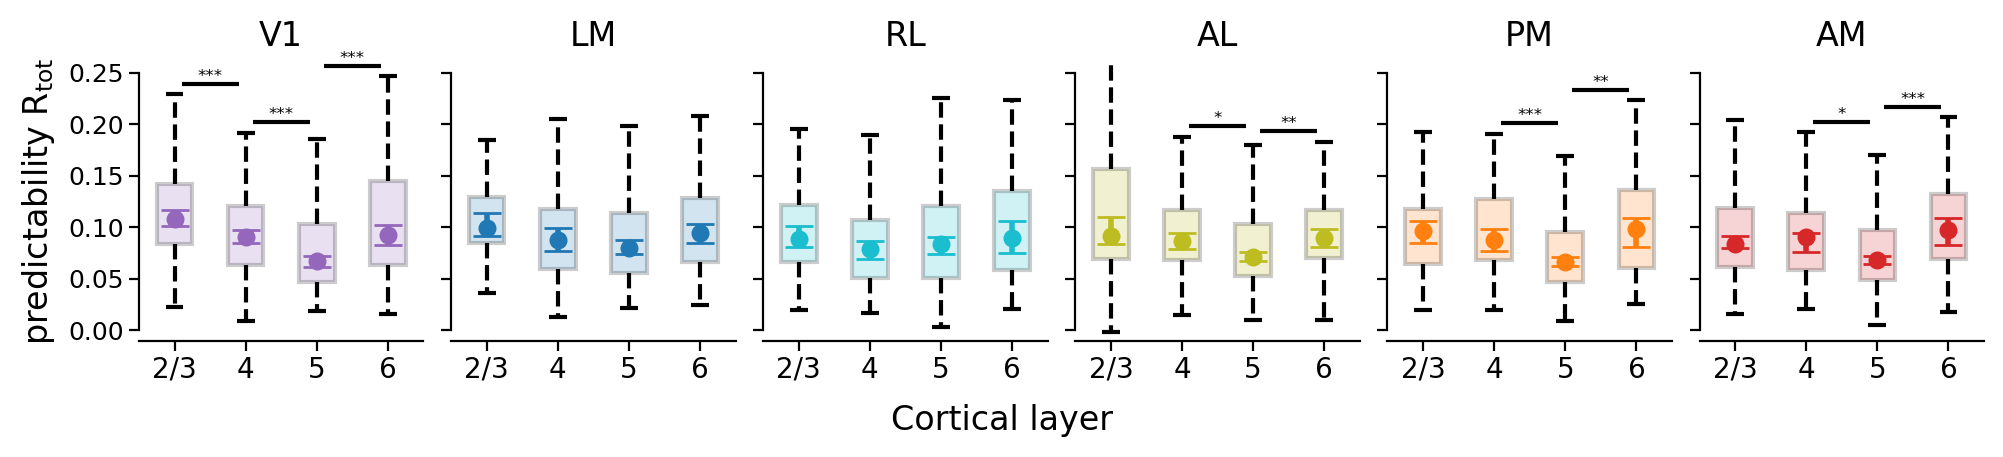

In [11]:
measure = "R_tot"
fig, axs = plt.subplots(1, len(areas), figsize=(10, 2), sharey=True)

plot_layerwise(
    fig,
    axs,
    measure,
    df=df_mean,
    areas=areas,
    structure_names=structure_names,
    structure_colors=structure_colors,
)

plt.tight_layout()
# plt.text(-10, -0.1, "Cortical layer", ha="center", fontsize=12)
fig.text(0.5, -0.07, "Cortical layer", ha="center", fontsize=12)
# Adjust spacing between subplots
# plt.subplots_adjust(hspace=0.5)
plt.savefig("../figs/layerwise_predictability.png", dpi=600, bbox_inches="tight")
plt.show()

### Plot for intrinsic timescale

TODO: Plot in log-space? 

VISp 2 0.13862727554776816
VISp 4 0.2355998642713067
VISp 5 0.47509815341825223
VISp 6 0.6382699511695391
VISl 2 0.21033585036531027
VISl 4 0.27212411039122375
VISl 5 0.444996786107004
VISl 6 0.6760784913039618
VISrl 2 0.17349942802824808
VISrl 4 0.26610458415616395
VISrl 5 0.36587027923006077
VISrl 6 0.5138591653331732
VISal 2 0.1721478854586337
VISal 4 0.3694579791117513
VISal 5 0.5070872441706626
VISal 6 0.6194669720268617
VISpm 2 0.25013063173980465
VISpm 4 0.3155726865477321
VISpm 5 0.6685080168055862
VISpm 6 0.6296039949315935
VISam 2 0.2254766931919913
VISam 4 0.49363682277768994
VISam 5 0.5738367791444748
VISam 6 0.5704099636320108


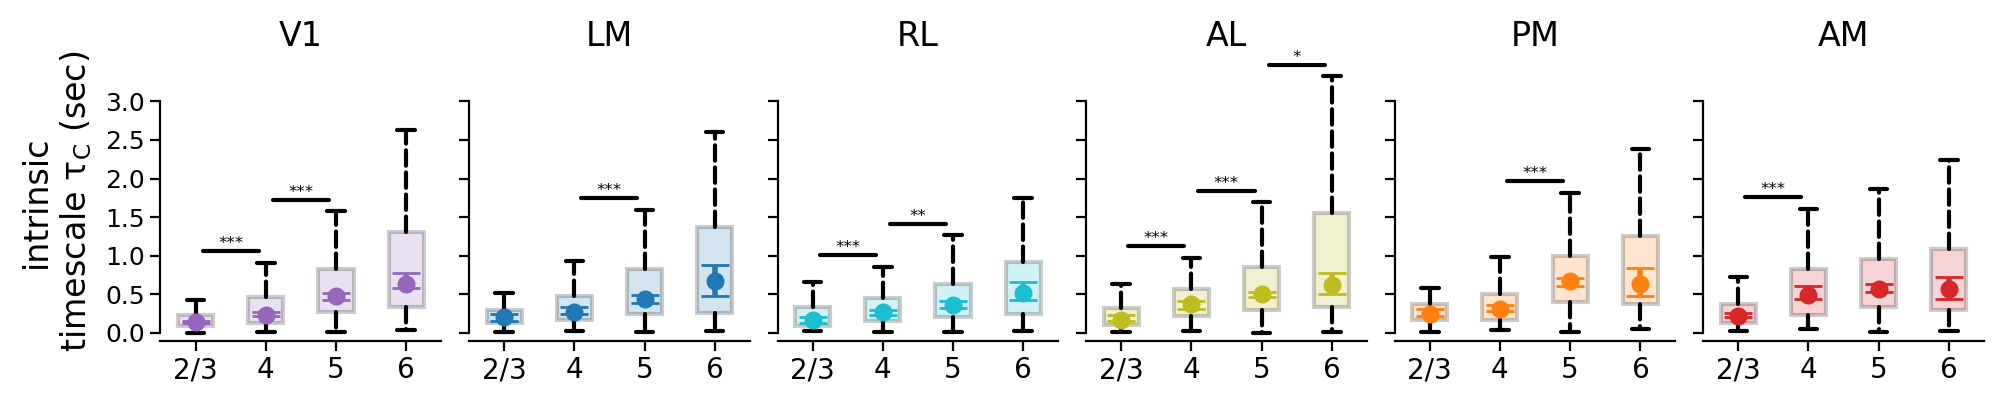

In [15]:
measure = "tau_double"
fig, axs = plt.subplots(1, len(areas), figsize=(10, 2), sharey=True)

plot_layerwise(
    fig,
    axs,
    measure,
    df=df_mean,
    areas=areas,
    structure_names=structure_names,
    structure_colors=structure_colors,
)
fig.tight_layout()
plt.savefig("../figs/layerwise_intrinsic_timescale.png", dpi=600, bbox_inches="tight")
plt.show()

### Plot for information timescale

VISp 2 0.02596722865908974
VISp 4 0.033409573941693145
VISp 5 0.05612432220830462
VISp 6 0.07403502187598177
VISl 2 0.03452169820555859
VISl 4 0.04383553926034303
VISl 5 0.060830242056183384
VISl 6 0.07647439719499702
VISrl 2 0.02978878680512127
VISrl 4 0.03530271707980184
VISrl 5 0.052012020880254056
VISrl 6 0.06992986351671497
VISal 2 0.03156060923872043
VISal 4 0.04327843589754055
VISal 5 0.06758884627819312
VISal 6 0.08816794053000047
VISpm 2 0.04367422076538115
VISpm 4 0.04197901838070378
VISpm 5 0.07163849685938448
VISpm 6 0.08765387681377831
VISam 2 0.039322371198923
VISam 4 0.055538344349980805
VISam 5 0.07034683880641983
VISam 6 0.07152924786400486


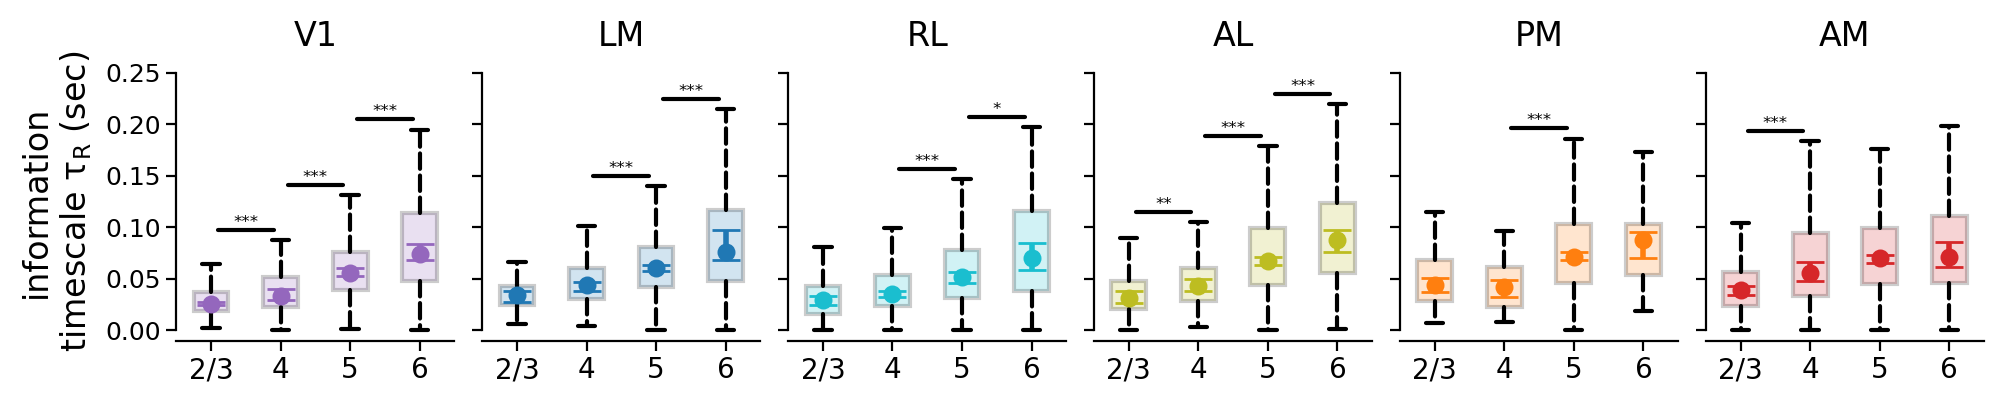

In [16]:
measure = "tau_R"
fig, axs = plt.subplots(1, len(areas), figsize=(10, 2), sharey=True)

plot_layerwise(
    fig,
    axs,
    measure,
    df=df_mean,
    areas=areas,
    structure_names=structure_names,
    structure_colors=structure_colors,
)
plt.tight_layout()
plt.savefig("../figs/layerwise_information_timescale.png", dpi=600, bbox_inches="tight")
plt.show()

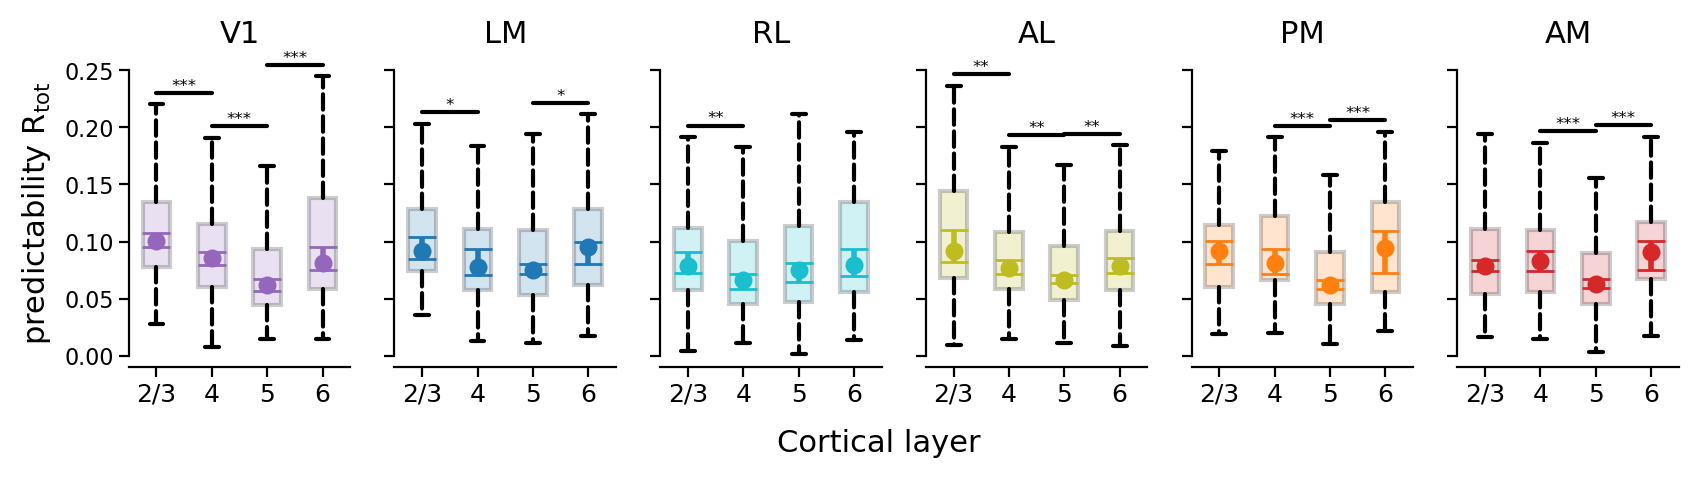

In [20]:
# Plot R_tot per layer
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu

structure_colors = {
    "V1": "#9467BD",
    "LM": "#2078B4",
    "RL": "#1ABECF",
    "AL": "#BDBD21",
    "PM": "#FF7F0F",
    "AM": "#D62729",
    "LGN": "#F4C9E7",
    "LP": "#AAD9AB",
    "thalamus_grouped": "#999999",
    "V1_grouped": "#4C4C4C",
    "higher_grouped": "#4C4C4C",
}


def get_CI_median(data):
    N_data = len(data)
    median_data = np.sort(
        np.nanmedian(np.random.choice(data, size=(10000, N_data)), axis=1)
    )
    CI_lo = median_data[249]
    CI_hi = median_data[9749]
    return CI_lo, CI_hi


# boxplot parameters
boxprops = dict(linewidth=1.5, edgecolor="black")
medianprops = dict(linestyle="-", linewidth=2.5, color="red")
whiskerprops = dict(linewidth=1.5, linestyle="--", color="black")
capprops = dict(linewidth=1.5, linestyle="-", color="black")

areas = ["VISp", "VISl", "VISrl", "VISal", "VISpm", "VISam"]
fig, axs = plt.subplots(1, len(areas), figsize=(10, 2), sharey=True)


for i, area in enumerate(areas):
    axs[i].set_title(structure_names[area], fontsize=11, loc="center")
    color = structure_colors[structure_names[area]]
    # df_mean.query(f"ecephys_structure_acronym == '{area}'").groupby("layer")["R_tot"].median().plot(ax=axs[i], title=structure_names[area])
    # iterate over unique layers in df_mean for given area and plot boxplot over R_tot values
    R_tot_data_per_layer = []
    for j, layer in enumerate([2, 4, 5, 6]):
        R_tot_data = df_mean.query(f"ecephys_structure_acronym == '{area}'")["R_tot"][
            df_mean["layer"] == layer
        ].values
        R_tot_data_per_layer.append(R_tot_data)
        boxplot = axs[i].boxplot(
            R_tot_data,
            positions=[j],
            widths=0.5,
            showfliers=False,
            patch_artist=True,
            boxprops=boxprops,
            medianprops=medianprops,
            whiskerprops=whiskerprops,
            capprops=capprops,
        )
        # remove median from boxplot
        boxplot["medians"][0].set_linewidth(0.0)
        boxplot["boxes"][0].set_facecolor(color)
        boxplot["boxes"][0].set_alpha(0.2)
        # add median value
        median = np.median(R_tot_data)
        axs[i].scatter(j, median, marker="o", color=color, s=30, zorder=10)
        # add error bars
        # Compute confidence interval on median from bootstrap samples
        R_tot_per_layer_low, R_tot_per_layer_high = get_CI_median(R_tot_data)
        axs[i].errorbar(
            j,
            median,
            yerr=[[median - R_tot_per_layer_low], [R_tot_per_layer_high - median]],
            fmt="_",
            color=color,
            linewidth=2,
            capsize=5,
            zorder=10,
        )
        # add p-value
        if j > 0:
            layer1_R_tot = R_tot_data_per_layer[j - 1]
            layer2_R_tot = R_tot_data_per_layer[j]
            y_prev = y
            # Perform Mann-Whitney U test
            statistic, p_value = mannwhitneyu(layer1_R_tot, layer2_R_tot)
            x1, x2 = j - 1, j
            y, h, col = boxplot["whiskers"][1].get_ydata()[1], 0.01, "k"
            y_max = np.amax([y, y_prev])
            # Check significance and add brackets on top of box plots
            if p_value < 0.001:
                # y = 1.2 + j*0.5
                axs[i].plot(
                    [x1, x1, x2, x2],
                    [y_max + h, y_max + h, y_max + h, y_max + h],
                    linewidth=1.5,
                    color=col,
                )
                axs[i].text(
                    (x1 + x2) * 0.5,
                    y_max + h,
                    "***",
                    ha="center",
                    va="bottom",
                    color=col,
                )
            elif p_value < 0.01:
                # y = 1.2 + j*0.5
                axs[i].plot(
                    [x1, x1, x2, x2],
                    [y_max + h, y_max + h, y_max + h, y_max + h],
                    linewidth=1.5,
                    color=col,
                )
                axs[i].text(
                    (x1 + x2) * 0.5,
                    y_max + h,
                    "**",
                    ha="center",
                    va="bottom",
                    color=col,
                )
            elif p_value < 0.05:
                # y = 1.2 + j*0.5
                axs[i].plot(
                    [x1, x1, x2, x2],
                    [y_max + h, y_max + h, y_max + h, y_max + h],
                    linewidth=1.5,
                    color=col,
                )
                axs[i].text(
                    (x1 + x2) * 0.5, y_max + h, "*", ha="center", va="bottom", color=col
                )
        else:
            y = boxplot["whiskers"][1].get_ydata()[1]
    axs[i].set_xticks(np.arange(len(np.unique(layers)[2:])))
    axs[i].spines["top"].set_bounds(0, 0)
    # axs[i].spines["bottom"].set_bounds(0,3)
    # axs[i].spines["left"].set_bounds(0,6)
    axs[i].set_ylim([-0.01, 0.26])
    axs[i].spines["right"].set_bounds(0, 0)
    axs[i].spines["left"].set_bounds(0, 0.25)
    axs[i].set_xticklabels(["2/3", "4", "5", "6"], fontsize=9)
    # plt.xticks(fontsize=9)

axs[0].set_ylabel(r"predictability $R_{\mathregular{tot}}$", fontsize=11)
# # Set x-axis labels
plt.xticks(np.arange(len(np.unique(layers)[2:])), ["2/3", "4", "5", "6"], fontsize=9)
plt.yticks(fontsize=9)
# # Set common x-axis label
fig.text(0.5, -0.1, "Cortical layer", ha="center", fontsize=11)

# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.5)

# Show the plot
plt.show()

VISp 2 23.552123552123554 %
VISp 4 24.517374517374517 %
VISp 5 38.22393822393823 %
VISp 6 13.030888030888029 %
VISl 2 8.75912408759124 %
VISl 4 21.897810218978105 %
VISl 5 51.82481751824818 %
VISl 6 17.37226277372263 %
VISrl 2 17.663817663817664 %
VISrl 4 35.04273504273504 %
VISrl 5 36.60968660968661 %
VISrl 6 10.3988603988604 %
VISal 2 10.378378378378377 %
VISal 4 19.35135135135135 %
VISal 5 52.43243243243243 %
VISal 6 17.72972972972973 %
VISpm 2 18.632478632478634 %
VISpm 4 13.162393162393164 %
VISpm 5 57.43589743589743 %
VISpm 6 10.76923076923077 %
VISam 2 20.723684210526315 %
VISam 4 14.692982456140353 %
VISam 5 54.05701754385965 %
VISam 6 10.526315789473683 %


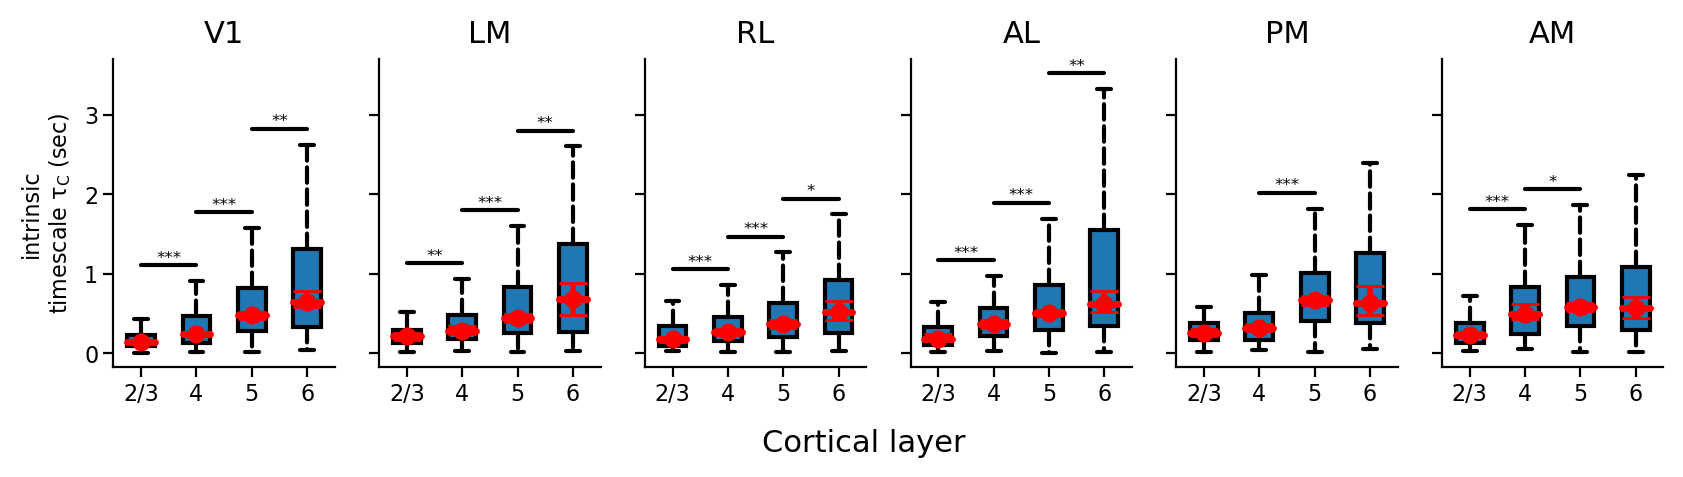

In [29]:
# Plot median tau_C per layer
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu

def get_CI_median(data):
    N_data = len(data)
    median_data = np.sort(np.nanmedian(np.random.choice(data, size=(10000, N_data)), axis=1))
    CI_lo = median_data[249]
    CI_hi = median_data[9749]
    return CI_lo, CI_hi

# boxplot parameters
boxprops = dict(linewidth=1.5, edgecolor='black')
medianprops = dict(linestyle='-', linewidth=2.5, color='red')
whiskerprops = dict(linewidth=1.5, linestyle='--', color='black')
capprops = dict(linewidth=1.5, linestyle='-', color='black')

areas = ['VISp','VISl','VISrl','VISal','VISpm','VISam']
fig, axs = plt.subplots(1, len(areas), figsize=(10, 2), sharey=True)


for i, area in enumerate(areas):
    axs[i].set_title(structure_names[area], fontsize = 11, loc='center')
    # df_mean.query(f"ecephys_structure_acronym == '{area}'").groupby("layer")["tau_double"].median().plot(ax=axs[i], title=structure_names[area])
    if i == 0:
        axs[i].set_ylabel("intrinsic\n" + r"timescale $τ_{\mathregular{C}}$ (sec)")   
    # iterate over unique layers in df_mean for given area and plot boxplot over tau_double values
    tau_double_data_per_layer = []
    n_area = df_mean.query(f"ecephys_structure_acronym == '{area}'")["tau_double"].count()
    for j, layer in enumerate([2,4,5,6]): 
        tau_double_data = df_mean.query(f"ecephys_structure_acronym == '{area}'")["tau_double"][df_mean["layer"]==layer].values
        print(area, layer, f"{len(tau_double_data)/n_area * 100} %")
        tau_double_data_per_layer.append(tau_double_data)
        boxplot = axs[i].boxplot(tau_double_data, positions=[j], widths=0.5, showfliers=False,
            patch_artist=True, boxprops=boxprops, medianprops=medianprops,
            whiskerprops=whiskerprops, capprops=capprops)
        # add median value  
        median = np.median(tau_double_data)
        axs[i].scatter(j, median, marker='o', color='red', s=30, zorder = 10)
        # add error bars
        # Compute confidence interval on median from bootstrap samples
        tau_double_per_layer_low, tau_double_per_layer_high = get_CI_median(tau_double_data)
        axs[i].errorbar(j, median, yerr=[[median - tau_double_per_layer_low], [tau_double_per_layer_high- median]],
                fmt='_', color='red', linewidth=2, capsize=5, zorder = 10)
        # add p-value
        if j > 0:
            layer1_tau_double = tau_double_data_per_layer[j-1]
            layer2_tau_double = tau_double_data_per_layer[j]

            # Perform Mann-Whitney U test
            statistic, p_value = mannwhitneyu(layer1_tau_double, layer2_tau_double)

            # Check significance and add brackets on top of box plots
            if p_value < 0.001:
                x1, x2 = j-1 , j 
                y, h, col = boxplot['whiskers'][1].get_ydata()[1], 0.2, 'k'
                # y = 1.2 + j*0.5
                axs[i].plot([x1, x1, x2, x2], [y + h, y + h, y + h, y + h], linewidth=1.5, color=col)
                axs[i].text((x1 + x2) * 0.5, y + h, '***', ha='center', va='bottom', color=col)
            elif p_value < 0.01:
                x1, x2 = j-1 , j 
                y, h, col = boxplot['whiskers'][1].get_ydata()[1], 0.2, 'k'
                # y = 1.2 + j*0.5
                axs[i].plot([x1, x1, x2, x2], [y + h, y + h, y + h, y + h], linewidth=1.5, color=col)
                axs[i].text((x1 + x2) * 0.5, y + h, '**', ha='center', va='bottom', color=col)
            elif p_value < 0.05:
                x1, x2 = j-1 , j 
                y, h, col = boxplot['whiskers'][1].get_ydata()[1], 0.2, 'k'
                # y = 1.2 + j*0.5
                axs[i].plot([x1, x1, x2, x2], [y + h, y + h, y + h, y + h], linewidth=1.5, color=col)
                axs[i].text((x1 + x2) * 0.5, y + h, '*', ha='center', va='bottom', color=col)
        

    axs[i].set_xticks(np.arange(len(np.unique(layers)[2:])))
    axs[i].spines["top"].set_bounds(0,0)
    # axs[i].spines["bottom"].set_bounds(0,3)
    # axs[i].spines["left"].set_bounds(0,6)
    # axs[i].set_ylim([0.0,0.25])
    axs[i].spines["right"].set_bounds(0,0)
    axs[i].set_xticklabels(["2/3", "4", "5", "6"])


# # Set x-axis labels
plt.xticks(np.arange(len(np.unique(layers)[2:])), ["2/3", "4", "5", "6"])

# # Set common x-axis label
fig.text(0.5, -0.1, 'Cortical layer', ha='center', fontsize=11)

# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.5)

# Show the plot
plt.show()


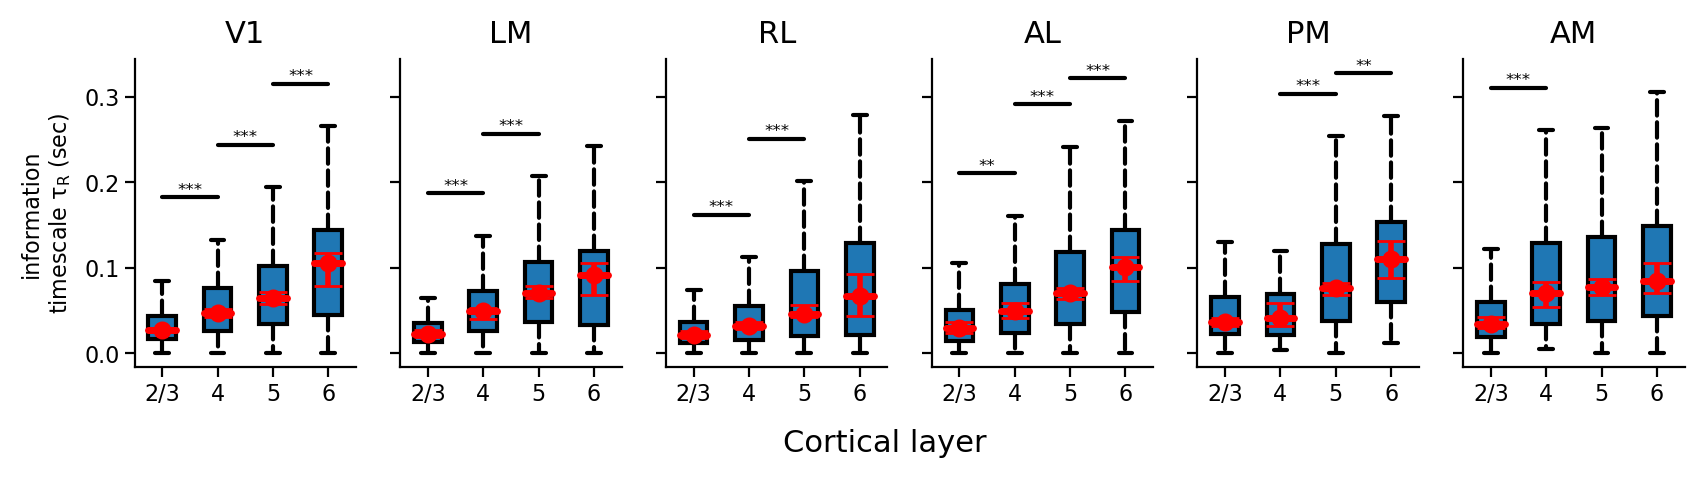

In [13]:
# Plot median tau_R per layer
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu

def get_CI_median(data):
    N_data = len(data)
    median_data = np.sort(np.nanmedian(np.random.choice(data, size=(10000, N_data)), axis=1))
    CI_lo = median_data[249]
    CI_hi = median_data[9749]
    return CI_lo, CI_hi

# boxplot parameters
boxprops = dict(linewidth=1.5, edgecolor='black')
medianprops = dict(linestyle='-', linewidth=2.5, color='red')
whiskerprops = dict(linewidth=1.5, linestyle='--', color='black')
capprops = dict(linewidth=1.5, linestyle='-', color='black')

areas = ['VISp','VISl','VISrl','VISal','VISpm','VISam']
fig, axs = plt.subplots(1, len(areas), figsize=(10, 2), sharey=True)


for i, area in enumerate(areas):
    axs[i].set_title(structure_names[area], fontsize = 11, loc='center')
    # df_mean.query(f"ecephys_structure_acronym == '{area}'").groupby("layer")["tau_R"].median().plot(ax=axs[i], title=structure_names[area])
    if i == 0:
        axs[i].set_ylabel("information\n" + r"timescale $τ_{\mathregular{R}}$ (sec)")   
    # iterate over unique layers in df_mean for given area and plot boxplot over tau_R values
    tau_R_data_per_layer = []
    for j, layer in enumerate([2,4,5,6]): 
        tau_R_data = df_mean.query(f"ecephys_structure_acronym == '{area}'")["tau_R"][df_mean["layer"]==layer].values
        tau_R_data_per_layer.append(tau_R_data)
        boxplot = axs[i].boxplot(tau_R_data, positions=[j], widths=0.5, showfliers=False,
            patch_artist=True, boxprops=boxprops, medianprops=medianprops,
            whiskerprops=whiskerprops, capprops=capprops)
        # add median value  
        median = np.median(tau_R_data)
        axs[i].scatter(j, median, marker='o', color='red', s=30, zorder = 10)
        # add error bars
        # Compute confidence interval on median from bootstrap samples
        tau_R_per_layer_low, tau_R_per_layer_high = get_CI_median(tau_R_data)
        axs[i].errorbar(j, median, yerr=[[median - tau_R_per_layer_low], [tau_R_per_layer_high- median]],
                fmt='_', color='red', linewidth=2, capsize=5, zorder = 10)
        # add p-value
        if j > 0:
            layer1_tau_R = tau_R_data_per_layer[j-1]
            layer2_tau_R = tau_R_data_per_layer[j]

            # Perform Mann-Whitney U test
            statistic, p_value = mannwhitneyu(layer1_tau_R, layer2_tau_R)

            # Check significance and add brackets on top of box plots
            if p_value < 0.001:
                x1, x2 = j-1 , j 
                y, h, col = boxplot['whiskers'][1].get_ydata()[1], 0.05, 'k'
                # y = 1.2 + j*0.5
                axs[i].plot([x1, x1, x2, x2], [y + h, y + h, y + h, y + h], linewidth=1.5, color=col)
                axs[i].text((x1 + x2) * 0.5, y + h, '***', ha='center', va='bottom', color=col)
            elif p_value < 0.01:
                x1, x2 = j-1 , j 
                y, h, col = boxplot['whiskers'][1].get_ydata()[1], 0.05, 'k'
                # y = 1.2 + j*0.5
                axs[i].plot([x1, x1, x2, x2], [y + h, y + h, y + h, y + h], linewidth=1.5, color=col)
                axs[i].text((x1 + x2) * 0.5, y + h, '**', ha='center', va='bottom', color=col)
            elif p_value < 0.05:
                x1, x2 = j-1 , j 
                y, h, col = boxplot['whiskers'][1].get_ydata()[1], 0.05, 'k'
                # y = 1.2 + j*0.5
                axs[i].plot([x1, x1, x2, x2], [y + h, y + h, y + h, y + h], linewidth=1.5, color=col)
                axs[i].text((x1 + x2) * 0.5, y + h, '*', ha='center', va='bottom', color=col)
        

    axs[i].set_xticks(np.arange(len(np.unique(layers)[2:])))
    axs[i].spines["top"].set_bounds(0,0)
    # axs[i].spines["bottom"].set_bounds(0,3)
    # axs[i].spines["left"].set_bounds(0,6)
    # axs[i].set_ylim([0.0,0.25])
    axs[i].spines["right"].set_bounds(0,0)
    axs[i].set_xticklabels(["2/3", "4", "5", "6"])


# # Set x-axis labels
plt.xticks(np.arange(len(np.unique(layers)[2:])), ["2/3", "4", "5", "6"])

# # Set common x-axis label
fig.text(0.5, -0.1, 'Cortical layer', ha='center', fontsize=11)

# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.5)

# Show the plot
plt.show()


In [12]:
df_mean.to_csv("df_mean.csv")

### Test 2D representation in Rtot tau_R plane

In [ ]:
# Plot R_tot vs tau_R for each layer and area in a scatter plot, with squares for the medians with confidence intervals on the medians
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu

areas = ['VISp','VISl','VISrl','VISal','VISpm','VISam']
layers = [2,4,5,6]

def get_CI_median(data):
    N_data = len(data)
    median_data = np.sort(np.nanmedian(np.random.choice(data, size=(10000, N_data)), axis=1))
    CI_lo = median_data[249]
    CI_hi = median_data[9749]
    return CI_lo, CI_hi


fig, axs = plt.subplots(2, 3, figsize=(15, 10), sharex=True, sharey=True)
axs = axs.flatten()
for i, area in enumerate(areas):
    for j, layer in enumerate(layers):
        df = df_mean.query(f"ecephys_structure_acronym == '{area}'")
        df = df.query(f"layer == {layer}")
        # axs[i].scatter(df["tau_R"], df["R_tot"], s=1)
        axs[i].set_title(area)
        axs[i].set_xlabel("tau_R")
        axs[i].set_ylabel("R_tot")
        # axs[i].set_xlim(0, 0.2)
        # axs[i].set_ylim(0, 0.5)
        # Add a color scheme for the layers that is gradually changing for a nice seaborn look
        color = (j+1)/len(layers)
        # add seaborn scheme
        axs[i].plot(df["tau_R"].median(), df["R_tot"].median(), "s", color=(color, 0, 1-color), markersize=8)
        tau_low, tau_high = get_CI_median(df["tau_R"])
        R_tot_low, R_tot_high = get_CI_median(df["R_tot"])
        axs[i].errorbar(df["tau_R"].median(), df["R_tot"].median(), xerr=[[df["tau_R"].median() - tau_low], [tau_high- df["tau_R"].median()]], yerr=[[df["R_tot"].median() - R_tot_low], [R_tot_high- df["R_tot"].median()]], color=(color, 0, 1-color))
        axs[i].text(0.1, 0.12, f"n = {len(df)}")
        axs[i].text(0.1, 0.115, f"p = {mannwhitneyu(df['tau_R'], df['R_tot'])[1]:.2e}")
# set ylim to be the same for all subplots
axs[0].set_ylim(0.04, 0.12)
axs[0].set_xlim(0, 0.1)
plt.tight_layout()
plt.show()